Loading the dataset


In [7]:
import pandas as pd

# Load the Excel file
file_path = './data/883eax2-sup-0002.xlsx'
df = pd.read_excel(file_path)

Exploration of the data

Dataset shape: (4758, 39)
Column types:
 ID_api                   object
Winter_mortality          int64
Age                      object
Activity                 object
Beekeep_for              object
Qualif                   object
Training                 object
Coop_treat               object
Bee_population_size      object
Country                  object
Apiary_Size              object
Production               object
Apiarist_book            object
Org_member               object
Continue                 object
Breed                    object
Chronic_Depop            object
ClinSign_Brood           object
ClinSign_Honeybees       object
H_Rate_ColMortality      object
H_Rate_HoneyMortality    object
OtherEvent               object
VarroaMites              object
QueenProblems            object
Management               object
Swarm_bought             object
Swarm_produced           object
Queen_bought             object
Queen_produced           object
MidSeason_Target         object

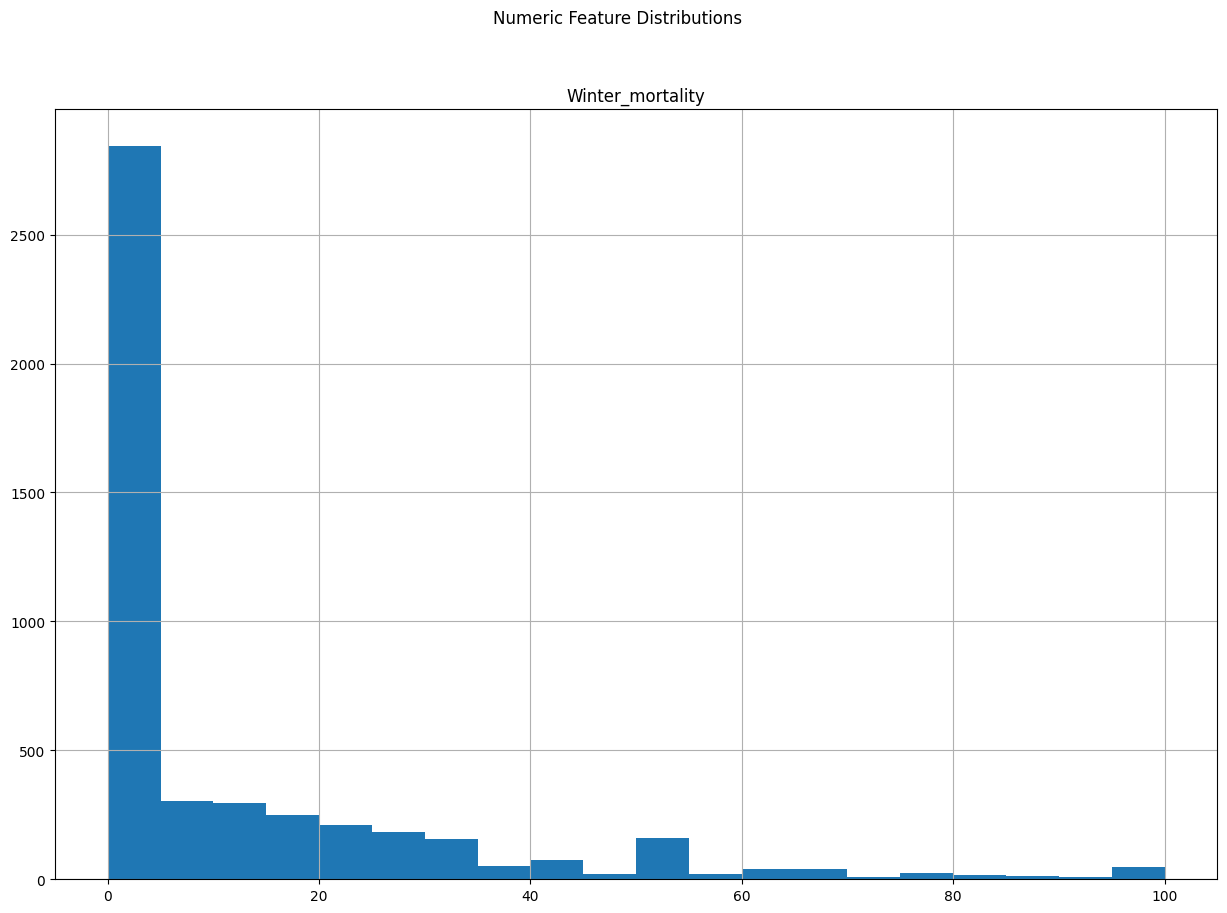

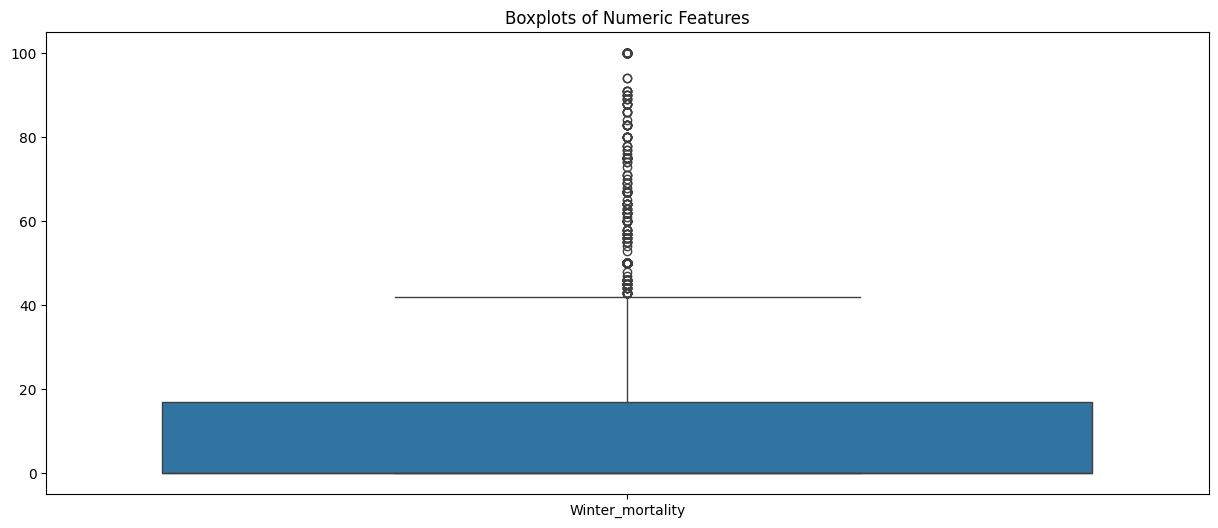

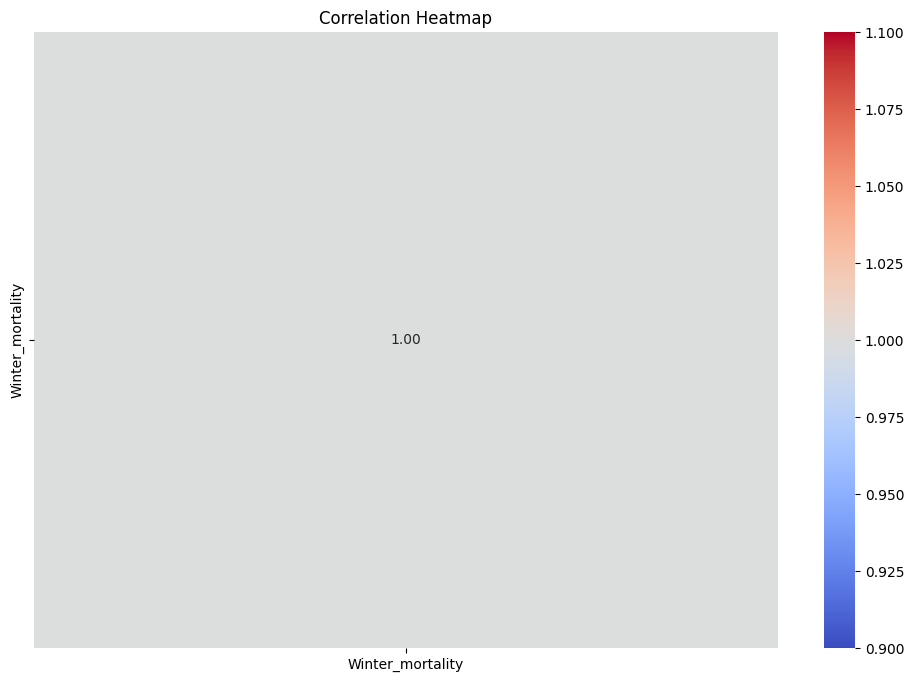


Column: ID_api
ID_api
1000_A    1
1003_A    1
1004_A    1
1006_A    1
1007_A    1
1008_A    1
1009_A    1
1010_A    1
1011_A    1
1012_A    1
Name: count, dtype: int64

Column: Age
Age
3___45-65           2610
4___Over 65         1064
2___30-45            915
1___Less than 30     169
Name: count, dtype: int64

Column: Activity
Activity
Hobby           3079
Professional     860
Part_time        819
Name: count, dtype: int64

Column: Beekeep_for
Beekeep_for
3___More than 5 years    3906
2___2-5 years             610
1___Less than 2 years     242
Name: count, dtype: int64

Column: Qualif
Qualif
No     2722
Yes    2036
Name: count, dtype: int64

Column: Training
Training
Yes    3267
No     1491
Name: count, dtype: int64

Column: Coop_treat
Coop_treat
Yes    3024
No     1734
Name: count, dtype: int64

Column: Bee_population_size
Bee_population_size
1___Less than 51 colonies     3351
2___51 - 100                   535
6___More than 300 colonies     349
3___101 - 150                  204
4__

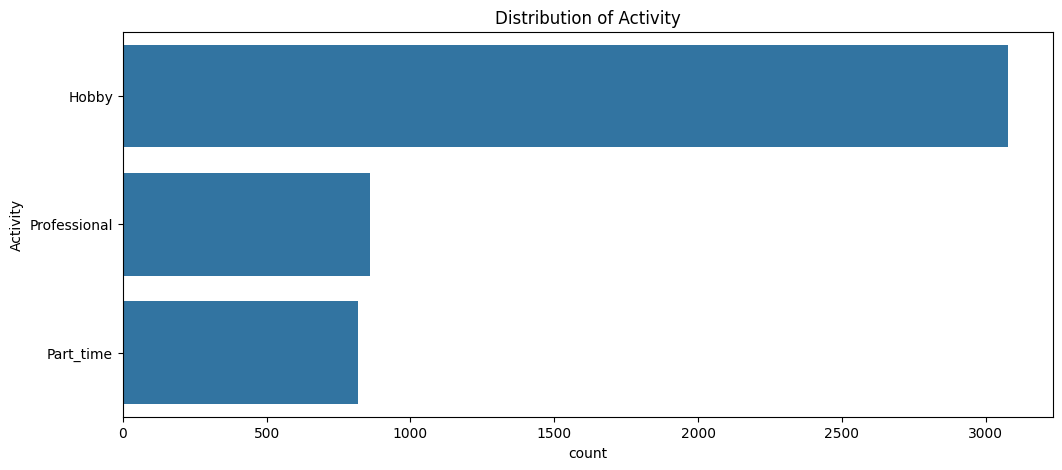

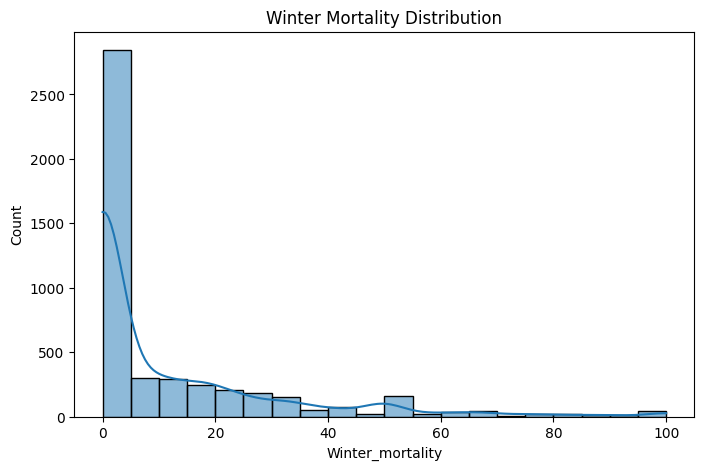

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic info
print("Dataset shape:", df.shape)
print("Column types:\n", df.dtypes)
print("First 5 rows:\n", df.head())
# 2. Summary statistics
summary_stats = df.describe(include='all')  # include='all' for non-numeric too
print("Summary statistics:\n", summary_stats)

# 3. Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# 4. Correlation matrix for numeric variables
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()
print("Correlation matrix:\n", corr_matrix)

# 5. Visualizations
# Histogram for distributions
df[numeric_cols].hist(figsize=(15,10), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Boxplots to detect outliers
plt.figure(figsize=(15,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots of Numeric Features")
plt.show()

# Heatmap of correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Categorical columns
cat_cols = df.select_dtypes(include='object').columns

# Frequency counts for categorical columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts().head(10))  # top 10 categories

# Bar plots for some categorical features
plt.figure(figsize=(12,5))
sns.countplot(y='Activity', data=df, order=df['Activity'].value_counts().index)
plt.title('Distribution of Activity')
plt.show()

# Distribution of target
plt.figure(figsize=(8,5))
sns.histplot(df['Winter_mortality'], bins=20, kde=True)
plt.title('Winter Mortality Distribution')
plt.show()

Data preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Drop ID
# df = df.drop(columns=['ID_api'])

# 2. Handle missing values
df['Environment'] = df['Environment'].fillna(df['Environment'].mode()[0])

# check if remaining missing values are left
print("remaining missing values", df.isnull().sum())


# 3. Convert numeric-like categorical columns
num_like_cols = ['Age', 'Beekeep_for', 'Bee_population_size', 'Apiary_Size',
                 'Swarm_bought', 'Swarm_produced', 'Queen_bought', 'Queen_produced']

# we are trying to extract the numeric part before any delimiters
for col in num_like_cols:
    df[col] = df[col].apply(lambda x: int(str(x).split('___')[0].split('__')[0])) # example: "1___Less than 30" becomes 1

# 4. Encode binary categorical columns as 0/1
binary_cols = ['Qualif','Training','Coop_treat','Apiarist_book','Org_member','Continue',
               'Chronic_Depop','ClinSign_Brood','ClinSign_Honeybees','H_Rate_ColMortality',
               'H_Rate_HoneyMortality','OtherEvent','VarroaMites','QueenProblems',
               'VarroosisV1','ChronicParalysisV1','AmericanFoulbroodV1','NosemosisV1',
               'EuropeanFoulbroodV1','Migration','Merger']

for col in binary_cols:
    df[col] = df[col].map({'Yes':1,'No':0,'Suffering':1,'Not_Suffering':0})

# 5. Identify categorical and numeric features
categorical_cols = ['Activity','Country','Production','Breed','Management',
                    'MidSeason_Target','Environment','Program']

numeric_cols = [col for col in df.columns if col not in categorical_cols + ['Winter_mortality']]

# 6. Split data into features and target
X = df.drop(columns=['Winter_mortality'])
y = df['Winter_mortality']

# 7. Train/Validation/Test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




ordinal_cols = ['Age','Beekeep_for','Bee_population_size','Apiary_Size',
                'Swarm_bought','Swarm_produced','Queen_bought','Queen_produced']
categorical_cols = ['Activity','Country','Production','Breed','Management',
                    'MidSeason_Target','Environment','Program']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', StandardScaler(), ordinal_cols),      # scale ordinal features
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # binary features remain 0/1
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)



remaining missing values Winter_mortality         0
Age                      0
Activity                 0
Beekeep_for              0
Qualif                   0
Training                 0
Coop_treat               0
Bee_population_size      0
Country                  0
Apiary_Size              0
Production               0
Apiarist_book            0
Org_member               0
Continue                 0
Breed                    0
Chronic_Depop            0
ClinSign_Brood           0
ClinSign_Honeybees       0
H_Rate_ColMortality      0
H_Rate_HoneyMortality    0
OtherEvent               0
VarroaMites              0
QueenProblems            0
Management               0
Swarm_bought             0
Swarm_produced           0
Queen_bought             0
Queen_produced           0
MidSeason_Target         0
Environment              0
VarroosisV1              0
ChronicParalysisV1       0
AmericanFoulbroodV1      0
NosemosisV1              0
EuropeanFoulbroodV1      0
Migration                0
Mer